# Ringtrial

> Evaluation Resnet 18 pre-trained on OSSL dataset on ringtrial data.


To do:

    - finetune on ringtrial
    - normalize on ossl statistics

## Runpod setup

In [ ]:
# setting up pod and pip install uhina
# accessing a pod terminal

# 1. To get access to the pod ip adress: runpodctl get pod -a
# 2. ssh into the pod: ssh root@<ip-address> -p 58871 -i ~/.ssh/id_ed25519

# git clone https://github.com/franckalbinet/uhina.git
# pip install uhina
# runpodctl send im-bw 
# runpodctl send ossl-tfm.csv


## Loading data

In [ ]:
import pandas as pd
from pathlib import Path
import fastcore.all as fc

from fastai.data.all import *
from fastai.vision.all import *
from multiprocessing import cpu_count
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)

In [ ]:
src = '../../_data/ringtrial-tfm/im-targets-lut.csv'
df = pd.read_csv(src)
df['lab'] = df['fname'].str.split('-rt', n=1).str[0]
df.head()

,fname,kex,lab
0,agrocares-rt-01.png,0.238276,agrocares
1,agrocares-rt-02.png,0.209848,agrocares
2,agrocares-rt-03.png,0.255487,agrocares
3,agrocares-rt-04.png,0.404965,agrocares
4,agrocares-rt-05.png,0.469860,agrocares


In [ ]:
df[df.lab == "kssl"]

,fname,kex,lab
483,kssl-rt-01.png,0.238276,kssl
484,kssl-rt-02.png,0.209848,kssl
485,kssl-rt-03.png,0.255487,kssl
486,kssl-rt-04.png,0.404965,kssl
487,kssl-rt-05.png,0.469860,kssl
488,kssl-rt-06.png,0.495470,kssl
489,kssl-rt-07.png,0.393716,kssl
490,kssl-rt-08.png,0.106628,kssl
491,kssl-rt-09.png,0.976900,kssl
492,kssl-rt-10.png,0.315519,kssl


## Quantizer

In [ ]:
@delegates()
class Quantize(RandTransform):
    "Quantize B&W image into `num_colors` colors."
    split_idx = None
    def __init__(self, 
        num_colors:int=10,
        verbose:bool=False,
        n_percentiles_valid:int=100, # how many different quantization to generate for valid set
        seed:int|None=41, # Seed for random number generator used to generate fixed augmentation for validation set
        start:float=np.random.uniform(1, 50),
        steps = np.random.randint(5, 100),
        **kwargs
    ):
        store_attr()
        super().__init__(**kwargs)
        self.counter_valid = 0
        self.percentiles = None
        self.percentiles_valid = self.generate_percentiles_valid(n=n_percentiles_valid, seed=self.seed)

    def before_call(self, 
        b, 
        split_idx:int # Index of the train/valid dataset (0: train, 1: valid)
    ):
        self.idx = split_idx
        
    def get_random_percentiles(self, seed:int|None=None):
        if seed is not None:
            np.random.seed(seed)
        # start = np.random.uniform(1, 50)
        start = self.start
        end = np.random.uniform(90.1, 99.5)
        # steps = np.random.randint(5, 100)
        steps = self.steps
        return torch.linspace(start=start, end=end, steps=steps)

    def generate_percentiles_valid(self, n:int=100, seed:int|None=None):
        return [self.get_random_percentiles(seed=self.seed) for i in range(n)]
    
    def get_percentiles(self):
        if self.idx == 1:
            return self.percentiles_valid[self.counter_valid%len(self.percentiles_valid)]
        else:
            return self.get_random_percentiles()
    
    def encodes(self, x:Image.Image):
        im_tensor = image2tensor(x)[0, :, :]
        
        percentiles = self.get_percentiles()
        levels = torch.quantile(im_tensor.float(), percentiles / 100)
        im_quant = torch.bucketize(im_tensor.float(), levels)
        
        cmap = plt.get_cmap('Spectral_r')
        im_color = tensor(cmap(im_quant.float() / im_quant.max())[:,:,:3])
        im_color = im_color.permute(2, 0, 1)
        return to_image(im_color)

## Evaluate on ringtrial

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, RegressionBlock),
                   get_x=ColReader(0, pref='../../_data/ringtrial-tfm/im/'),
                   get_y=ColReader(1),
                   splitter=RandomSplitter(valid_pct=0, seed=41),
                   batch_tfms=[RatioResize(224)],
                   item_tfms=[Quantize()])

In [ ]:
class ModelEvaluator:
    def __init__(self, model_path, dblock):
        self.learn = load_learner(model_path, cpu=True)
        self.dblock = dblock

    def evaluate(self, df_selected, batch_size=16, use_tta=False, tta_n=4):
        dls = self.dblock.dataloaders(df_selected, bs=batch_size)
        if use_tta:
            val_preds, val_targets = self.learn.tta(dl=dls.train, n=tta_n)
        else:
            val_preds, val_targets = self.learn.get_preds(dl=dls.train)
        
        r2 = r2_score(val_targets, val_preds)
        return val_preds, val_targets, r2

In [ ]:
model_path = './models/650-4000-epoch-25-lr-3e-3.pkl'
evaluator = ModelEvaluator(model_path, dblock)

In [ ]:

# For KSSL data
df_kssl = df[df.lab == 'kssl']
val_preds_kssl, val_targets_kssl, r2_kssl = evaluator.evaluate(df_kssl)
print(f"R2 score for KSSL: {r2_kssl}")

# For another lab, e.g., 'agrocares'
df_agrocares = df[df.lab == 'agrocares']
val_preds_agrocares, val_targets_agrocares, r2_agrocares = evaluator.evaluate(df_agrocares)
print(f"R2 score for Agrocares: {r2_agrocares}")


In [ ]:
df[df.lab == 'iaea-aug2022'].head()

,fname,kex,lab
414,iaea-aug2022-rt-01.png,0.238276,iaea-aug2022
415,iaea-aug2022-rt-02.png,0.209848,iaea-aug2022
416,iaea-aug2022-rt-03.png,0.255487,iaea-aug2022
417,iaea-aug2022-rt-04.png,0.404965,iaea-aug2022
418,iaea-aug2022-rt-05.png,0.469860,iaea-aug2022


In [ ]:
def predict_with_transforms(learn, img_path, n_predictions=5):
    # Load the image
    img = PILImage.create(img_path)
    
    # Create instances of the transforms
    ratio_resize = RatioResize(224)
    quantize = Quantize()
    
    predictions = []
    for _ in range(n_predictions):
        # Apply transforms
        img_resized = ratio_resize(img)
        img_quantized = quantize(img_resized)
        
        # Predict
        pred, _, _ = learn.predict(img_quantized)
        predictions.append(pred[0])
    
    from statistics import mode
    # Calculate mean and standard deviation
    mean_pred = np.mean(predictions)
    std_pred = np.std(predictions)
    median_pred = np.median(predictions)
    mode_pred = mode(predictions)
    return mean_pred, std_pred, median_pred, mode_pred, predictions

In [ ]:

# Use the function
# fname = 'iaea-aug2022-rt-09.png'
fname = 'kssl-rt-17.png'
img_path = f'/Users/franckalbinet/pro/dev/uhina/_data/ringtrial-tfm/im/{fname}'

mean, std, median, mode, all_preds = predict_with_transforms(learn, img_path, n_predictions=50)

print('ground truth:', df[df.fname == fname])
print(f"Mean prediction: {mean:.4f}")
print(f"Standard deviation: {std:.4f}")
print(f"Median prediction: {median:.4f}")
print(f"Mode prediction: {mode:.4f}")
print(f"All predictions: {all_preds}")

ground truth:               fname       kex   lab
499  kssl-rt-17.png  0.595782  kssl
Mean prediction: 0.1662
Standard deviation: 0.0320
Median prediction: 0.1645
Mode prediction: 0.1844
All predictions: [0.18438775837421417, 0.17716039717197418, 0.16031770408153534, 0.16707229614257812, 0.18959830701351166, 0.15226536989212036, 0.16372862458229065, 0.17417171597480774, 0.17889682948589325, 0.16423699259757996, 0.188875213265419, 0.14576807618141174, 0.1566668152809143, 0.09790365397930145, 0.1308053880929947, 0.17296013236045837, 0.15731824934482574, 0.17920437455177307, 0.14278826117515564, 0.16127324104309082, 0.13960005342960358, 0.18992598354816437, 0.16427884995937347, 0.14472602307796478, 0.18485793471336365, 0.16480687260627747, 0.13524892926216125, 0.18884441256523132, 0.15464714169502258, 0.1693478673696518, 0.17386141419410706, 0.18275123834609985, 0.14987140893936157, 0.1553349494934082, 0.16351105272769928, 0.17232175171375275, 0.35185903310775757, 0.15632209181785583, 0.1

In [ ]:
# np.expm1(0.14)


(array([4., 6., 5., 3., 8., 7., 5., 6., 3., 3.]),
 array([-0.00725316,  0.02543666,  0.05812647,  0.09081629,  0.1235061 ,
         0.15619592,  0.18888573,  0.22157554,  0.25426536,  0.28695517,
         0.31964499]),
 <BarContainer object of 10 artists>)

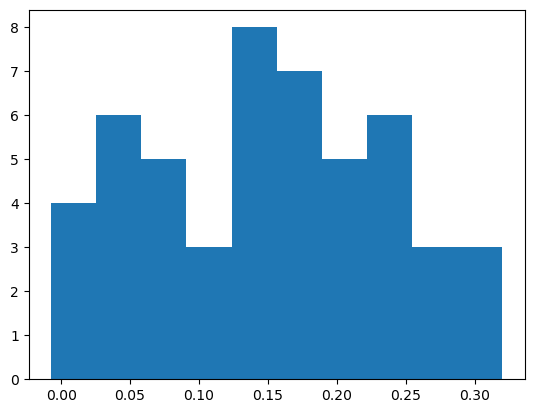

In [ ]:
plt.hist(all_preds, bins=10)

In [ ]:
learn.predict('/Users/franckalbinet/pro/dev/uhina/_data/ringtrial-tfm/im/kssl-rt-01.png')



((0.09267915785312653,), tensor([0.0927]), tensor([0.0927]))

In [ ]:
learn.predict('/Users/franckalbinet/pro/dev/uhina/_data/ringtrial-tfm/im/kssl-rt-01.png')

((0.09267915785312653,), tensor([0.0927]), tensor([0.0927]))

In [ ]:
 df.lab.unique()

array(['agrocares', 'argonne', 'csu-il', 'eth-alpha-1', 'eth-alpha-2',
       'eth-vertex', 'iaea-aug2022', 'kssl', 'landcare', 'lesotho', 'msu',
       'osu', 'rothamsted', 'scion', 'ughent', 'uiuc', 'usp',
       'uwisc-fine', 'woodwell-alpha', 'woodwell-vertex'], dtype=object)

In [ ]:
df_selected = df[df.lab == 'iaea-aug2022']
val_preds, val_targets, r2 = evaluator.evaluate(df_selected, use_tta=True, tta_n=20)
print(f"R2 score for {lab}: {r2}")

R2 score for woodwell-vertex: -0.15211879211144286


In [ ]:
for lab in df.lab.unique():
    df_selected = df[df.lab == lab]
    val_preds, val_targets, r2 = evaluator.evaluate(df_selected)
    print(f"R2 score for {lab}: {r2}")

R2 score for agrocares: 0.014122075944125623


R2 score for argonne: 0.5618941400520052


R2 score for csu-il: 0.6464306666816627


R2 score for eth-alpha-1: -0.1233998393908351


R2 score for eth-alpha-2: 0.09006596673660539


R2 score for eth-vertex: 0.33785760711622026


R2 score for iaea-aug2022: -0.22897592584264603


R2 score for kssl: 0.7675183252973982


R2 score for landcare: 0.3347716092538108


R2 score for lesotho: 0.1994847886421538


R2 score for msu: 0.6330126211637213


R2 score for osu: 0.2888193069607097


R2 score for rothamsted: 0.6123880591167077


R2 score for scion: 0.4239510692393975


R2 score for ughent: 0.2432637924624087


R2 score for uiuc: -1.0256510250885067


R2 score for usp: -0.06284453596671646


R2 score for uwisc-fine: 0.09148350985156484


R2 score for woodwell-alpha: -0.21525611440215542


R2 score for woodwell-vertex: 0.15222785800263994


In [ ]:
for lab in df.lab.unique():
    df_selected = df[df.lab == lab]
    val_preds, val_targets, r2 = evaluator.evaluate(df_selected, use_tta=True, tta_n=4)
    print(f"R2 score for {lab}: {r2}")

R2 score for agrocares: -0.03209495284966479


R2 score for argonne: 0.5107013047255626


R2 score for csu-il: 0.6847652879768744


R2 score for eth-alpha-1: -0.05316365067423634


R2 score for eth-alpha-2: 0.0340654504054313


R2 score for eth-vertex: 0.3142872806238588


R2 score for iaea-aug2022: -0.16586478504693658


R2 score for kssl: 0.7712529425042771


R2 score for landcare: 0.361515927635906


R2 score for lesotho: 0.3014982759822462


R2 score for msu: 0.6516961138864841


R2 score for osu: 0.3233388500136357


R2 score for rothamsted: 0.6081827159105113


R2 score for scion: 0.41571789574644646


R2 score for ughent: 0.2500409658517887


R2 score for uiuc: -1.0397764827662894


R2 score for usp: -0.10862361724770841


R2 score for uwisc-fine: 0.055873236631498235


R2 score for woodwell-alpha: -0.10852037342096654


R2 score for woodwell-vertex: 0.23576914131667936


## Fine-tuning on ringtrial

In [ ]:
# np.expm1(np.log1p(2))

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, RegressionBlock),
                   get_x=ColReader(0, pref='../../_data/ringtrial-tfm/im/'),
                   get_y=ColReader(1),
                   splitter=RandomSplitter(valid_pct=0.2, seed=41),
                   batch_tfms=[RatioResize(224)],
                   item_tfms=[Quantize()])

In [ ]:
df.lab.unique()

array(['agrocares', 'argonne', 'csu-il', 'eth-alpha-1', 'eth-alpha-2',
       'eth-vertex', 'iaea-aug2022', 'kssl', 'landcare', 'lesotho', 'msu',
       'osu', 'rothamsted', 'scion', 'ughent', 'uiuc', 'usp',
       'uwisc-fine', 'woodwell-alpha', 'woodwell-vertex'], dtype=object)

In [ ]:
df_selected = df[df.lab == 'iaea-aug2022']
# dblock.summary(df_selected)

In [ ]:
# The last layer of the model is a Linear one: 512 -> 1
model = learn.model
model[-1][-1].in_features

512

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

def stratified_split(df, target_col, n_splits=2, test_size=0.2, random_state=42):
    # Create bins for the target values
    df_copy = df.copy()
    df_copy['target_bin'] = pd.cut(df_copy[target_col], bins=2, labels=False)
    
    # Create a StratifiedShuffleSplit object
    sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    
    # Get the indices for the splits
    splits = list(sss.split(df_copy, df_copy['target_bin']))
    
    # Remove the temporary 'target_bin' column
    df_copy.drop('target_bin', axis=1, inplace=True)
    
    return splits

# Usage example:
splits = stratified_split(df_selected, 'kex', n_splits=2)

# For train-validation split
train_idx, valid_idx = splits[0]

# For train-test split (if needed)
train_valid_idx, test_idx = splits[1]

# Create DataFrames
train_df = df_selected.iloc[train_idx]
valid_df = df_selected.iloc[valid_idx]
test_df = df_selected.iloc[test_idx]

In [ ]:
len(train_df), len(valid_df), len(test_df)

(55, 14, 14)

In [ ]:
test_df

,fname,kex,lab
416,iaea-aug2022-rt-03.png,0.255487,iaea-aug2022
453,iaea-aug2022-rt-40.png,0.673883,iaea-aug2022
414,iaea-aug2022-rt-01.png,0.238276,iaea-aug2022
441,iaea-aug2022-rt-28.png,0.676835,iaea-aug2022
470,iaea-aug2022-rt-58.png,0.735776,iaea-aug2022
423,iaea-aug2022-rt-10.png,0.315519,iaea-aug2022
429,iaea-aug2022-rt-16.png,0.662054,iaea-aug2022
468,iaea-aug2022-rt-56.png,0.718293,iaea-aug2022
428,iaea-aug2022-rt-15.png,0.482117,iaea-aug2022
467,iaea-aug2022-rt-55.png,0.358884,iaea-aug2022


In [ ]:
def stratified_splitter(items):
    return [train_idx, valid_idx]

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, RegressionBlock),
                   get_x=ColReader(0, pref='../../_data/ringtrial-tfm/im/'),
                   get_y=ColReader(1),
                   splitter=stratified_splitter,
                   batch_tfms=[RatioResize(224)],
                   item_tfms=[Quantize()])

In [ ]:
dls = dblock.dataloaders(df_selected, bs=16)

In [ ]:
dls.train.n, dls.valid.n

(55, 14)

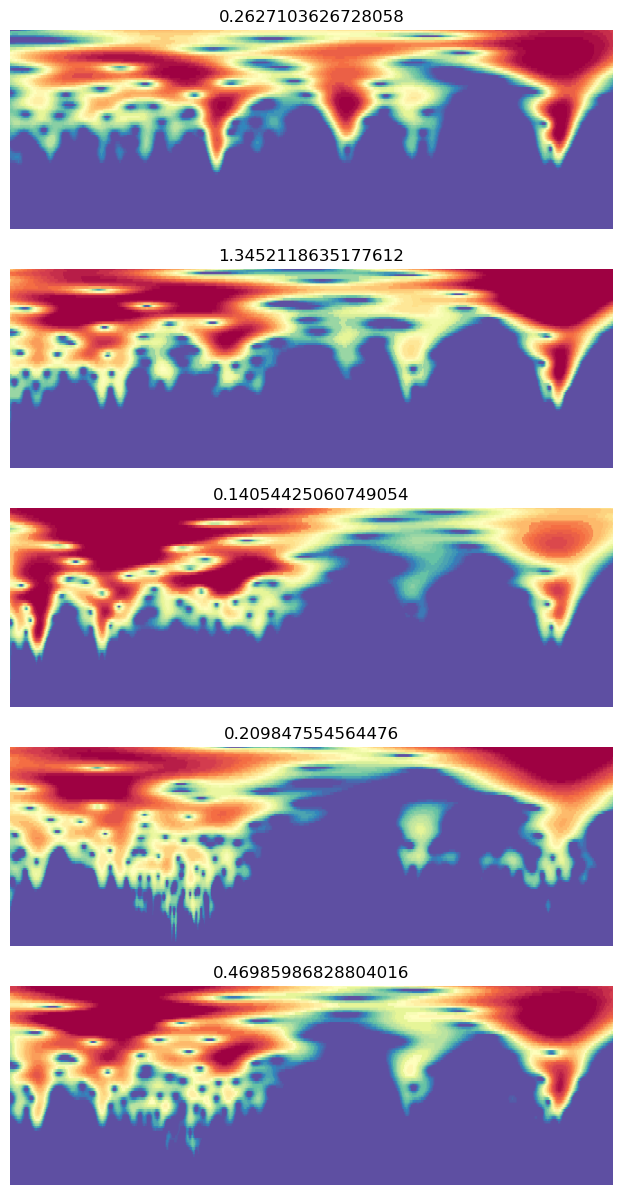

In [ ]:
dls.show_batch(nrows=5, ncols=1, figsize=(10, 15))

* **Question**: what if we train the Resnet on the 70 samples dataset directly?

In [ ]:
learn = vision_learner(dls, resnet18, pretrained=False, metrics=R2Score())

SuggestedLRs(valley=0.007585775572806597)

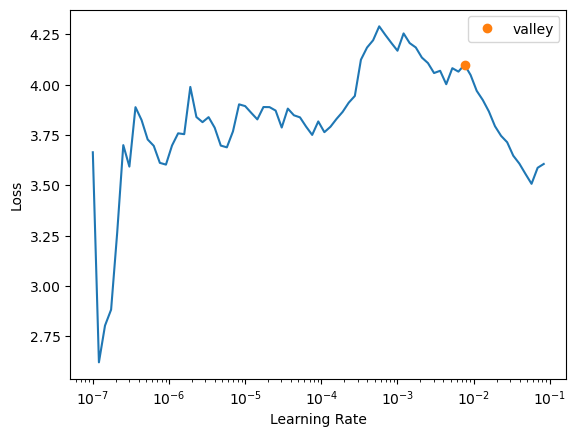

In [ ]:
learn.lr_find()

In [ ]:
# It doesn't work! (which is expected)
# learn.fit_one_cycle(20, 1e-4)

* **Question**: what if we fine-tune the Resnet18 pre-trained on OSSL with the 70 samples dataset?

In [ ]:
learn = load_learner ('./models/650-4000-epoch-25-lr-3e-3.pkl', cpu=True)

In [ ]:
learn.dls = dls

In [ ]:
# learn.summary()

In [ ]:
learn.freeze()

In [ ]:
# learn.summary()

SuggestedLRs(valley=0.0008317637839354575)

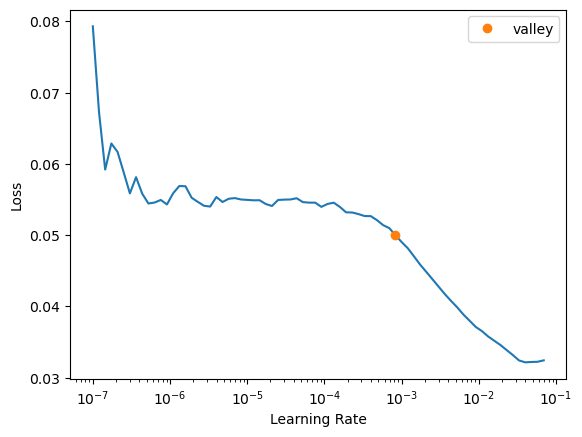

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(30, 1e-3)

epoch,train_loss,valid_loss,r2_score,time
0,0.077903,0.037129,0.258314,00:02
1,0.076334,0.021458,0.571359,00:01
2,0.072124,0.014571,0.708927,00:01
3,0.066230,0.012399,0.752316,00:01
4,0.064270,0.010071,0.798828,00:02
5,0.059700,0.009314,0.813946,00:02
6,0.053938,0.009872,0.802789,00:02
7,0.051297,0.011395,0.772383,00:01
8,0.049503,0.011330,0.773662,00:01
9,0.047049,0.010769,0.784873,00:01


### Evaluate fine-tuned model

In [ ]:
len(test_df)

14

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, RegressionBlock),
                   get_x=ColReader(0, pref='../../_data/ringtrial-tfm/im/'),
                   get_y=ColReader(1),
                   splitter=RandomSplitter(valid_pct=0, seed=41),
                   batch_tfms=[RatioResize(224)],
                   item_tfms=[Quantize()])

dls = dblock.dataloaders(test_df, bs=len(test_df))

In [ ]:
val_preds, val_targets = learn.get_preds(dl=dls.train)

In [ ]:
r2_score(val_targets, val_preds)

0.8494923109411353

In [ ]:
val_preds, val_targets = learn.tta(dl=dls.train, n=30)

In [ ]:
np.c_[val_preds, val_targets]

array([[0.52894515, 0.66205376],
       [0.18049915, 0.25548682],
       [0.2325106 , 0.23827647],
       [0.4207998 , 0.3588835 ],
       [0.6751771 , 0.6738828 ],
       [0.4935777 , 0.48211747],
       [0.6003827 , 0.6768349 ],
       [0.599208  , 0.71829337],
       [0.41319135, 0.46985987],
       [0.6111145 , 0.73577553],
       [0.3663083 , 0.24990232],
       [0.6267741 , 0.68159574],
       [0.17029428, 0.1476956 ],
       [0.32789648, 0.31551853]], dtype=float32)

In [ ]:
r2_score(val_targets, val_preds)

0.8578216317617187

| lab | lr | n_epochs (fine-tuning) | r2_score |  n_tta  |
|------|--------------|-------------------|----------|--------|
| kssl | 1e-3 | 5 | 0.89 | 30 |
| agrocares | 1e-3 | 20 | 0.75 | 30 |
| argonne | 1e-3 | 5 | 0.92 | 30 |
| iaea-aug2022 | 1e-3 | 30 | 0.86 | 30 |
| csu-il | 1e-3 | 5 | 0.85 | 30 |
| eth-alpha-1 | 1e-3 | 30 | 0.93 | 30 |




In [ ]:
learn.predict('/Users/franckalbinet/pro/dev/uhina/_data/ringtrial-tfm/im/kssl-rt-01.png')

((0.03432786837220192,), tensor([0.0343]), tensor([0.0343]))

### On single images

In [ ]:
def predict_with_transforms(learn, img_path, n_predictions=5):
    # Load the image
    img = PILImage.create(img_path)
    
    # Create instances of the transforms
    ratio_resize = RatioResize(224)
    quantize = Quantize()
    
    predictions = []
    for _ in range(n_predictions):
        # Apply transforms
        img_resized = ratio_resize(img)
        img_quantized = quantize(img_resized)
        
        # Predict
        pred, _, _ = learn.predict(img_quantized)
        predictions.append(pred[0])
    
    from statistics import mode
    # Calculate mean and standard deviation
    mean_pred = np.mean(predictions)
    std_pred = np.std(predictions)
    median_pred = np.median(predictions)
    mode_pred = mode(predictions)
    return mean_pred, std_pred, median_pred, mode_pred, predictions

In [ ]:
test_df

,fname,kex,lab
416,iaea-aug2022-rt-03.png,0.255487,iaea-aug2022
453,iaea-aug2022-rt-40.png,0.673883,iaea-aug2022
414,iaea-aug2022-rt-01.png,0.238276,iaea-aug2022
441,iaea-aug2022-rt-28.png,0.676835,iaea-aug2022
470,iaea-aug2022-rt-58.png,0.735776,iaea-aug2022
423,iaea-aug2022-rt-10.png,0.315519,iaea-aug2022
429,iaea-aug2022-rt-16.png,0.662054,iaea-aug2022
468,iaea-aug2022-rt-56.png,0.718293,iaea-aug2022
428,iaea-aug2022-rt-15.png,0.482117,iaea-aug2022
467,iaea-aug2022-rt-55.png,0.358884,iaea-aug2022


In [ ]:
learn.predict('/Users/franckalbinet/pro/dev/uhina/_data/ringtrial-tfm/im/iaea-aug2022-rt-03.png')

((0.1897062063217163,), tensor([0.1897]), tensor([0.1897]))

In [ ]:
def predict_with_tta_histogram(learn, img_path, n_tta=30):
    # Load the image
    img = PILImage.create(img_path)
    
    # Create a test DataLoader with a single image
    test_dl = learn.dls.test_dl([img])
    
    # Collect predictions
    all_preds = []
    for _ in range(n_tta):
        # Get prediction with TTA (n=1 for a single augmentation each time)
        preds, _ = learn.tta(dl=test_dl, n=1)
        all_preds.append(preds[0][0].item())  # Assuming single output
    
    all_preds = np.array(all_preds)
    
    # Calculate statistics
    mean_pred = np.mean(all_preds)
    std_pred = np.std(all_preds)
    median_pred = np.median(all_preds)
    
    return mean_pred, std_pred, median_pred, all_preds

Mean prediction: 0.6272
Standard deviation: 0.0139
Median prediction: 0.6331
All predictions: [0.63482308 0.60249484 0.64007974 0.64494681 0.64093387 0.6340127
 0.632195   0.61479533 0.61204851 0.61587656]
Ground truth: 0.7182933488149795


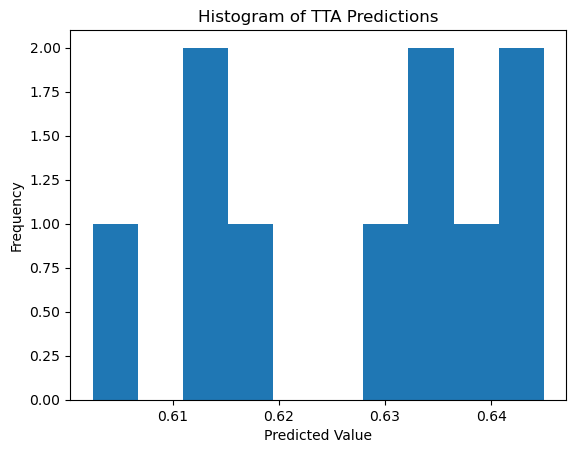

In [ ]:

# Use the function
fname = 'iaea-aug2022-rt-56.png'
img_path = Path('/Users/franckalbinet/pro/dev/uhina/_data/ringtrial-tfm/im/') / fname
mean, std, median, all_preds = predict_with_tta_histogram(learn, img_path, n_tta=10)

print(f"Mean prediction: {mean:.4f}")
print(f"Standard deviation: {std:.4f}")
print(f"Median prediction: {median:.4f}")
print(f"All predictions: {all_preds}")

# If you want to compare with the ground truth
print('Ground truth:', df[df.fname == fname]['kex'].values[0])

# Plot histogram
plt.hist(all_preds, bins=10)
plt.title('Histogram of TTA Predictions')
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Canonical fine-tuning
# from fastai.vision.all import *

# # Load the pretrained model
# learn = load_learner('./models/650-4000-epoch-25-lr-3e-3.pkl', cpu=False)

# # Prepare your new data
# path = 'path/to/your/data'
# dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, item_tfms=Resize(224), batch_tfms=aug_transforms())

# # Set the new data
# learn.dls = dls

# # Fine-tune the head of the model
# learn.freeze()
# # alternatively: learn.freeze_to(n)
# learn.lr_find()
# learn.fit_one_cycle(5, 3e-3)

# # Fine-tune the entire model
# learn.unfreeze()
# learn.lr_find()
# learn.fit_one_cycle(5, slice(1e-5, 1e-3))

In [ ]:
# learn = vision_learner(dls, resnet18, pretrained=False, metrics=R2Score()).to_fp16()


In [ ]:
# learn.lr_find()

SuggestedLRs(valley=0.002511886414140463)

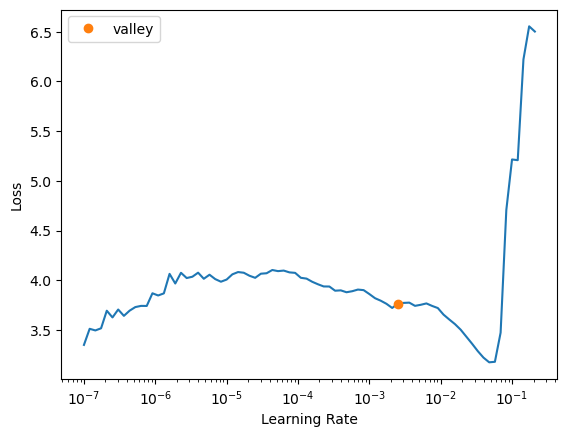

In [ ]:
# learn.lr_find()

In [ ]:
# learn.fit_one_cycle(5, 3e-3)

## Evaluation

In [ ]:
# Convert predictions and targets to numpy arrays
def assess_model(val_preds, val_targets):
    val_preds = val_preds.numpy().flatten()
    val_targets = val_targets.numpy()

    # Create a DataFrame with the results
    results_df = pd.DataFrame({
        'Predicted': val_preds,
        'Actual': val_targets
    })

    # Display the first few rows of the results
    print(results_df.head())

    # Calculate and print the R2 score
    from sklearn.metrics import r2_score
    r2 = r2_score(val_targets, val_preds)
    print(f"R2 Score on validation set: {r2:.4f}")

In [ ]:
dls.train.n

69

In [ ]:
val_preds, val_targets = learn.get_preds(dl=dls.train)
assess_model(val_preds, val_targets)

   Predicted    Actual
0   0.046272  0.210804
1   0.528189  0.976900
2   0.465372  0.469860
3   0.258100  0.338556
4   0.112802  0.147696
R2 Score on validation set: 0.7392


In [ ]:
val_preds, val_targets = learn.get_preds(dl=dls.train)
r2 = r2_score(val_targets, val_preds); r2

In [ ]:
r2 = r2_score(val_targets, val_preds); r2

0.7391959435205914

In [ ]:
scores = []
for n in range(1, 20):
    val_preds, val_targets = learn.tta(dl=dls.train, n=n)
    scores.append(r2_score(val_targets, val_preds))

[<matplotlib.lines.Line2D>]

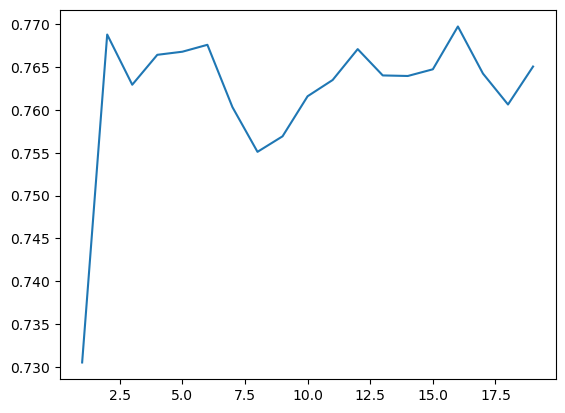

In [ ]:
x = list(range(1, 20))
plt.plot(x, scores)

In [ ]:
# EXAMPLE of TTA on single item
# from fastai.vision.all import *

# # Define your TTA transforms
# tta_tfms = [
#     RandomResizedCrop(224, min_scale=0.5),
#     Flip(),
#     Rotate(degrees=(-15, 15)),
#     Brightness(max_lighting=0.2),
#     Contrast(max_lighting=0.2)
# ]

# # Create a pipeline of TTA transformations
# tta_pipeline = Pipeline(tta_tfms)

# # Load your model
# learn = load_learner('path/to/your/model.pkl')

# # Define the input data (e.g., an image)
# input_data = PILImage.create('path/to/your/image.jpg')

# # Apply TTA transforms to the input data and make predictions
# predictions = []
# for _ in range(5):  # Apply 5 different augmentations
#     augmented_data = tta_pipeline(input_data)
#     prediction = learn.predict(augmented_data)
#     predictions.append(prediction)

# # Average the predictions
# average_prediction = sum(predictions) / len(predictions)

# print(average_prediction)

In [ ]:
# Assuming you have a new CSV file for your test data
# test_source = '../../_data/ossl-tfm/ossl-tfm-test.csv'
# test_df = pd.read_csv(test_source)

# # Create a new DataLoader for the test data
# test_dl = learn.dls.test_dl(test_df)

# # Get predictions on the test set
# test_preds, test_targets = learn.get_preds(dl=test_dl)

# # Now you can use test_preds and test_targets for further analysis

In [ ]:
assess_model(val_preds, val_targets)

   Predicted    Actual
0   0.312483  0.000000
1   0.126990  0.184960
2   0.365726  0.194201
3   0.239089  0.262364
4   0.402980  0.355799
R2 Score on validation set: 0.8325


In [ ]:
assess_model(val_preds_tta, val_targets_tta)

   Predicted    Actual
0   0.246857  0.000000
1   0.148590  0.184960
2   0.371643  0.194201
3   0.226535  0.262364
4   0.407333  0.355799
R2 Score on validation set: 0.8378


In [ ]:
val_preds_np = val_preds
val_targets_np = val_targets

# Apply the transformation: exp(y) - 1
val_preds_transformed = np.exp(val_preds_np) - 1
val_targets_transformed = np.exp(val_targets_np) - 1

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Predicted': val_preds_transformed,
    'Actual': val_targets_transformed
})

# Display the first few rows of the results
print(results_df.head())

# Calculate and print the R2 score
from sklearn.metrics import r2_score
r2 = r2_score(val_targets_transformed, val_preds_transformed)
print(f"R2 Score on validation set (after transformation): {r2:.4f}")

# Calculate and print the MAPE, handling zero values
def mean_absolute_percentage_error(y_true, y_pred):
    non_zero = (y_true != 0)
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

mape = mean_absolute_percentage_error(val_targets_transformed, val_preds_transformed)
print(f"Mean Absolute Percentage Error (MAPE) on validation set: {mape:.2f}%")

# Calculate and print the MAE as an alternative metric
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(val_targets_transformed, val_preds_transformed)
print(f"Mean Absolute Error (MAE) on validation set: {mae:.4f}")

   Predicted   Actual
0   0.366814  0.00000
1   0.135405  0.20317
2   0.441560  0.21434
3   0.270092  0.30000
4   0.496277  0.42732
R2 Score on validation set (after transformation): 0.6936
Mean Absolute Percentage Error (MAPE) on validation set: 50.72%
Mean Absolute Error (MAE) on validation set: 0.1956


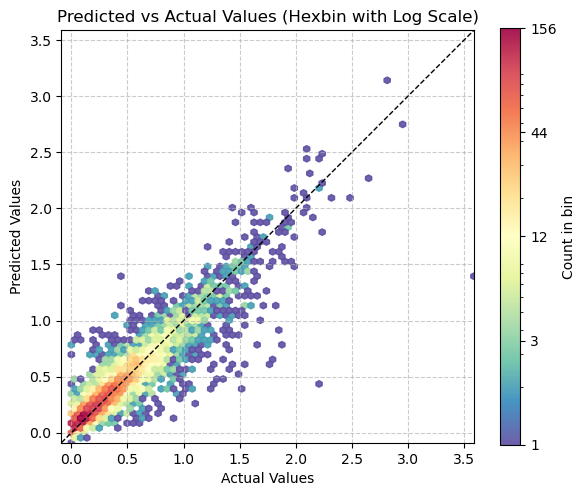

Min non-zero count in hexbins: 1.0
Max count in hexbins: 157.0


In [ ]:
plt.figure(figsize=(6, 6))

# Use logarithmic bins for the colormap
h = plt.hexbin(val_targets, val_preds, gridsize=65, 
               bins='log', cmap='Spectral_r', mincnt=1,
               alpha=0.9)

# Get the actual min and max counts from the hexbin data
counts = h.get_array()
min_count = counts[counts > 0].min()  # Minimum non-zero count
max_count = counts.max()

# Create a logarithmic colorbar
cb = plt.colorbar(h, label='Count in bin', shrink=0.73)
tick_locations = np.logspace(np.log10(min_count), np.log10(max_count), 5)
cb.set_ticks(tick_locations)
cb.set_ticklabels([f'{int(x)}' for x in tick_locations])

# Add the diagonal line
min_val = min(val_targets.min(), val_preds.min())
max_val = max(val_targets.max(), val_preds.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)

# Set labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Hexbin with Log Scale)')

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.65)

# Set the same limits for both axes
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# Make the plot square
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

# Print the range of counts in the hexbins
print(f"Min non-zero count in hexbins: {min_count}")
print(f"Max count in hexbins: {max_count}")

In [ ]:
path_model = Path('./models')
learn.export(path_model / '0.pkl')

## Inference

In [ ]:
ossl_source = Path('../../_data/ossl-tfm/img')
learn.predict(ossl_source / '0a0a0c647671fd3030cc13ba5432eb88.png')

((0.5229991674423218,), tensor([0.5230]), tensor([0.5230]))

In [ ]:
df[df['fname'] == '0a0a0c647671fd3030cc13ba5432eb88.png']

,fname,kex
28867,0a0a0c647671fd3030cc13ba5432eb88.png,0.525379


In [ ]:
np.exp(3) - 1

19.085536923187668

## Experiments:


Color scale: `viridis` | Discretization: `percentiles = [i for i in range(60, 100)]`

| Model     | Image Size | Learning Rate | Epochs | R2 Score | Time per Epoch | Finetuning | with axis ticks |
|-----------|------------|----------------|--------|----------|----------------|------------|----------------|
| ResNet-18 | 100        | 1e-3           | 10     | 0.648    | 05:12          | No        | Yes             |
| ResNet-18 | 224        | 2e-3           | 10     | 0.69     | 07:30          | No        | Yes             |
| ResNet-18 | 750 (original size)        |    1e-3        | 10     | 0.71          | 36:00          | No         | Yes             |
| ResNet-18 | 224        | 2e-3           | 20     |   0.704   | 07:30          | No        | Yes             |
| ResNet-18 | 224        | 2e-3           | 10     |   0.71   | 07:00          | No        | No             |
    

Discretization: `percentiles = [i for i in range(20, 100)]`

| Model     | Image Size | Learning Rate | Epochs | R2 Score | Time per Epoch | Finetuning | with axis ticks | colour scale |
|-----------|------------|---------------|--------|----------|----------------|------------|-----------------|--------------|
| ResNet-18 | 224        | 2e-3          | 10     | 0.7      | 05:12          | No         | No              | `viridis`    |
| ResNet-18 | 224        | 3e-3          | 10     | 0.71      | 05:12          | No         | No              | `jet`        |

From now on `with axis ticks` is always `No`.

Discretization: esimated on `10000` cwt power percentiles `[20, 30, 40, 50, 60, 70, 80, 90, 95, 97, 99]`

| Model     | Image Size | Learning Rate | Epochs | R2 Score | Time per Epoch | Finetuning | remark | colour scale |
|-----------|------------|---------------|--------|----------|----------------|------------|-----------------|--------------|
| ResNet-18 | 224        | 2e-3          | 10     | 0.71      | 05:12          | No         | None              | `jet`    |
| ResNet-18 | 224        | 2e-3         | 10     | 0.685      | 05:12          | No         | y range added              | `jet`    |


From now on random splitter with `10%` validation and random seed `41`.

Discretization: esimated on `10000` cwt power percentiles `[20, 30, 40, 50, 60, 70, 80, 90, 95, 97, 99]`

| Model     | Image Size | Learning Rate | Epochs | R2 Score | Time per Epoch | Finetuning | remark | colour scale |
|-----------|------------|---------------|--------|----------|----------------|------------|-----------------|--------------|
| ResNet-18 | 224        | 2e-3          | 10     | 0.7      | 05:12          | No         | Pre-train & normalize: True              | `jet`    |
| ResNet-18 | 224        | 2e-3          | 10     | 0.796     | 08:12          | No         | No Pre-train              | `jet`    |
| ResNet-18 | 224        | 3e-3          | 10     | 0.7     | 05:12          | No         | Pre-train & normalize: False            | `jet`    |
| ResNet-18 (id=0)| 224        | 2e-3          | 20     | **0.829**     | 08:12          | No         | No Pre-train (try 18 epochs)              | `jet`    |
